# Algorithms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# New Adaptive Epsilon-Greedy
# ==========================
class AdaptiveEpsilonGreedy:
    """
    Epsilon-Greedy variant with UCB-inspired adaptive exploration rate
    Exploration probability ε_t = min(1, k*sqrt(log(t)/n_min))
    where n_min is minimum pull count across arms
    
    Parameters:
    - num_arms: Number of arms/spreads
    - k: Exploration scaling factor
    """
    def __init__(self, num_arms, k):
        self.num_arms = num_arms
        self.k = k
        self.counts = np.zeros(num_arms)  # Pull counts per arm
        self.values = np.zeros(num_arms)  # Empirical reward averages
        self.t = 1  # Time step counter
        
    def select_arm(self):
        """Select arm using ε-greedy strategy with adaptive exploration rate"""
        if np.random.random() < self._calculate_epsilon():
            return np.random.randint(self.num_arms)  # Uniform exploration
        else:
            return np.argmax(self.values)  # Greedy exploitation
            
    def _calculate_epsilon(self):
        """Calculate adaptive exploration rate using UCB-style uncertainty"""
        n_min = np.min(self.counts) if np.all(self.counts > 0) else 1
        return min(1, self.k * np.sqrt(np.log(self.t) / n_min))
        
    def update(self, arm, reward):
        """Update arm estimates using incremental average"""
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1  # Increment time step

# ==========================
# Fixed Exploration Then Exploitation Greedy
# ==========================
class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if self.t <= self.exploration_steps:
            return (self.t - 1) % self.num_arms
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Epsilon-Greedy
# ==========================
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

# ==========================
# Epsilon-Greedy with Decaying Exploration
# ==========================
class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        epsilon = self.epsilon_schedule(self.t)
        if np.random.rand() < epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# UCB
# ==========================
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1
        
    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)
        
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# EXP3
# ==========================
class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1
        
    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)
        
    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

## Single-agent Stationary environment

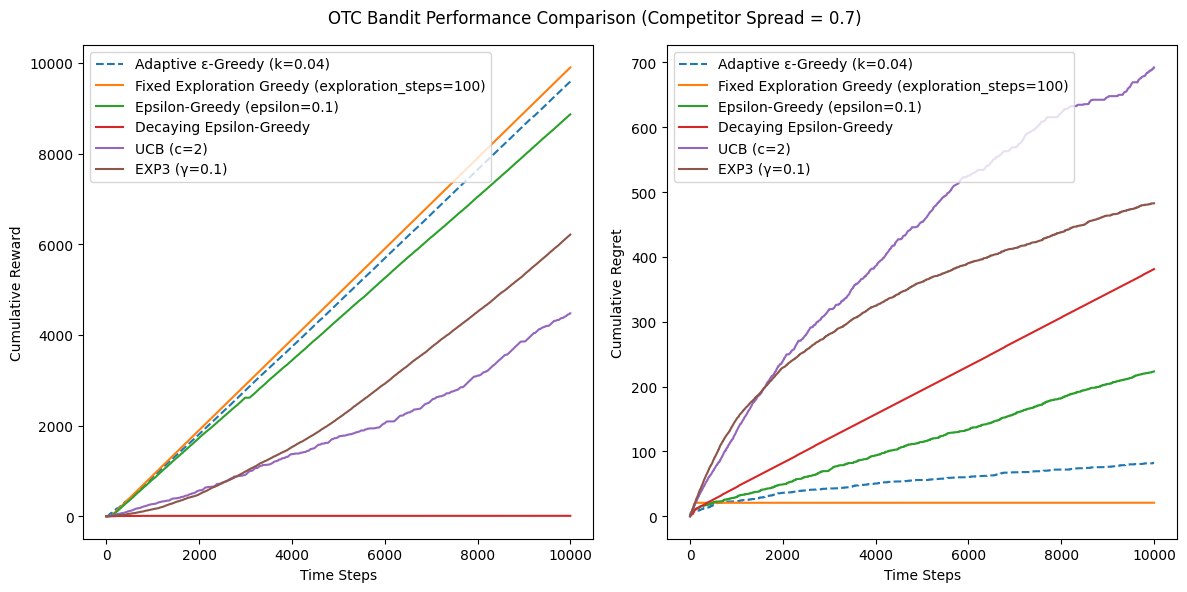

In [ ]:
"""
Multi-Armed Bandit Algorithms in OTC (Order-to-Cover) Market Environment
This code compares various bandit algorithms in a simulated financial market scenario
where agents compete through spread selection.
"""

# ==========================
# Setting Evironment
# ==========================
class OTCEnvironment:
    """
    Simulates an Order-to-Cover market environment with spread-based execution probabilities
    
    Parameters:
    - spreads: List of available spreads (arms)
    - competitor_spread: Fixed spread used by market competitor
    - alpha: Market competitiveness parameter (higher = more competitive)
    """
    def __init__(self, spreads, competitor_spread, alpha=0.3):
        self.spreads = np.array(spreads)  # Available spreads (arms)
        self.competitor_spread = competitor_spread  # Fixed competitor spread
        self.alpha = alpha  # Logistic decay steepness (market competitiveness)
        
    def get_execution_prob(self, s):
        """
        Calculate execution probability for a given spread using logistic function
        - Lower spreads (< competitor) have exponentially decreasing advantage
        - Higher spreads (>= competitor) have reduced execution probability
        """
        if s < self.competitor_spread:
            # Favorable spread: probability decreases with distance from competitor
            return 1 / (1 + np.exp(self.alpha * (self.competitor_spread - s)))
        else:
            # Unfavorable spread: additional penalty for being worse than competitor
            return 1 / (1 + np.exp(self.alpha * (s - self.competitor_spread + 0.1)))
        
    def pull_arm(self, arm):
        """Simulate arm pull with probabilistic reward (spread * execution probability)"""
        s = self.spreads[arm]  # Selected spread
        prob = self.get_execution_prob(s)  # Compute execution probability
        win = np.random.binomial(1, prob)  # Simulate execution (Avellaneda's Poisson intensity)
        return win * s  # Reward = spread * execution (risk-adjusted return from both papers)

# ==========================
# Experiment Runner
# ==========================
def run_experiment(bandit_class, bandit_params, env, num_steps):
    """
    Run bandit algorithm experiment and track performance metrics
    
    Parameters:
    - bandit_class: Algorithm class to test
    - bandit_params: Dictionary of algorithm parameters
    - env: OTCEvironment instance
    - num_steps: Number of iterations
    
    Returns:
    - cum_rewards: Cumulative correct arm selections
    - cum_regret: Cumulative regret compared to optimal
    """
    bandit = bandit_class(**bandit_params)
    rewards = []
    regrets = []
    
    # Precompute optimal arm once
    expected_rewards = [s * env.get_execution_prob(s) for s in env.spreads]
    optimal_arm = np.argmax(expected_rewards)
    optimal_reward = expected_rewards[optimal_arm]
    
    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        
        # Calculate instantaneous regret
        current_expected = env.spreads[arm] * env.get_execution_prob(env.spreads[arm])
        regret = optimal_reward - current_expected
        regrets.append(regret)
        rewards.append(1 if arm == optimal_arm else 0)
    
    return np.cumsum(rewards), np.cumsum(regrets)

# ==========================
# Experiment Setup
# ==========================

num_arms = 10
spreads = np.linspace(0.1, 1, num_arms) # Available spreads
competitor_spread = 0.7 # Competitor's fixed spread
alpha = 0.4 # High alpha means high competitiveness (steep execution prob curve)
env = OTCEnvironment( # Define environment
    spreads, 
    competitor_spread=competitor_spread,
    alpha=alpha
)
num_steps = 10000  # Simulation length 

# ==========================
# Algorithm Parameters
# ==========================

k = 0.04  # Adaptive ε-Greedy exploration scaling
exploration_steps = 100  # Fixed exploration phase length
epsilon = 0.1  # Standard ε-Greedy exploration rate
c = 2  # UCB exploration weight
gamma = 0.1  # EXP3 exploration parameter
def epsilon_schedule(t): # ε decay schedule for Decaying ε-Greedy
    #return 1 / (t + 1)
    #return 1 / np.sqrt(t + 1)
    return np.log(t+1)/(t+1)

# ==========================
# Running Experiments
# ==========================

# Adaptive ε-Greedy
adaptive_epsilon_greedy_reward, adaptive_epsilon_greedy_regret = run_experiment(AdaptiveEpsilonGreedy, {'num_arms': num_arms, 'k': k}, env, num_steps)
# Fixed exploration Greedy
fixed_exploration_greedy_reward, fixed_exploration_greedy_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': exploration_steps}, env, num_steps)
# ε-Greedy
epsilon_greedy_reward, epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': epsilon}, env, num_steps)
#Decaying ε-Greedy
decaying_epsilon_greedy_reward, decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
# UCB
ucb_reward, ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': c}, env, num_steps)
# EXP3
exp3_reward, exp3_regret = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': gamma}, env, num_steps)

# ==========================
# Visualization
# ==========================

plt.figure(figsize=(12, 6))

# Reward Plot
plt.subplot(1, 2, 1)

plt.plot(adaptive_epsilon_greedy_reward, label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(fixed_exploration_greedy_reward, label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(epsilon_greedy_reward, label=f'Epsilon-Greedy (epsilon={epsilon})')
plt.plot(decaying_epsilon_greedy_reward, label='Decaying Epsilon-Greedy')
plt.plot(ucb_reward, label=f'UCB (c={c})')
plt.plot(exp3_reward, label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()


# Regret Plot
plt.subplot(1, 2, 2)

plt.plot(adaptive_epsilon_greedy_regret, label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(fixed_exploration_greedy_regret, label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(epsilon_greedy_regret, label=f'Epsilon-Greedy (epsilon={epsilon})')
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')
plt.plot(ucb_regret, label=f'UCB (c={c})')
plt.plot(exp3_regret, label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.suptitle(f"OTC Bandit Performance Comparison (Competitor Spread = {competitor_spread})")
plt.tight_layout()
plt.show()

## Single-agent Non-stationary environment

[Step 2000] Competitor spread changed: 0.7 ➜ 0.7000000000000001
[Step 4000] Competitor spread changed: 0.7000000000000001 ➜ 0.30000000000000004
[Step 6000] Competitor spread changed: 0.30000000000000004 ➜ 0.30000000000000004
[Step 8000] Competitor spread changed: 0.30000000000000004 ➜ 0.30000000000000004
[Step 10000] Competitor spread changed: 0.30000000000000004 ➜ 0.2
[Step 2000] Competitor spread changed: 0.7 ➜ 0.7000000000000001
[Step 4000] Competitor spread changed: 0.7000000000000001 ➜ 0.30000000000000004
[Step 6000] Competitor spread changed: 0.30000000000000004 ➜ 0.30000000000000004
[Step 8000] Competitor spread changed: 0.30000000000000004 ➜ 0.30000000000000004
[Step 10000] Competitor spread changed: 0.30000000000000004 ➜ 0.2
[Step 2000] Competitor spread changed: 0.7 ➜ 0.7000000000000001
[Step 4000] Competitor spread changed: 0.7000000000000001 ➜ 0.30000000000000004
[Step 6000] Competitor spread changed: 0.30000000000000004 ➜ 0.30000000000000004
[Step 8000] Competitor spread c

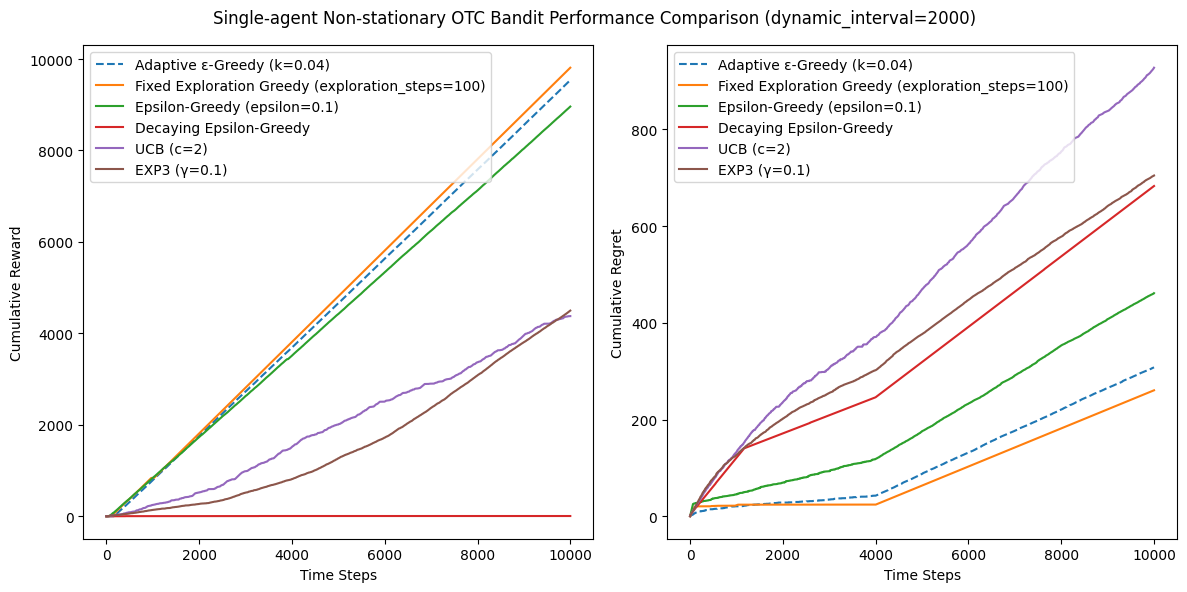

In [ ]:
# ==========================
# Non-stationary OTC Environment
# ==========================
class NonStationaryOTCEnvironment(OTCEnvironment):
    """
    Extends OTCEnvironment by periodically changing the competitor's spread,
    simulating a non-stationary environment (e.g., changing market conditions).
    
    Parameters:
    - dynamic_interval: Number of steps between environment changes
    """
    def __init__(self, spreads, competitor_spread=0.7, alpha=0.3, dynamic_interval=1000, seed=None):
        super().__init__(spreads, competitor_spread, alpha)
        self.dynamic_interval = dynamic_interval
        self.step_counter = 0
        self.rng = np.random.default_rng(seed)  # Use a dedicated RNG with seed

    def update_competitor_spread(self):
        """Periodically update competitor_spread to simulate market drift."""
        if self.step_counter % self.dynamic_interval == 0:
            old = self.competitor_spread
            self.competitor_spread = self.rng.choice(self.spreads)  # Use seeded RNG
            print(f"[Step {self.step_counter}] Competitor spread changed: {old} ➜ {self.competitor_spread}")

    def pull_arm(self, arm):
        """Override with time-dependent spread change"""
        self.step_counter += 1
        self.update_competitor_spread()
        return super().pull_arm(arm)
    
# ==========================
# Experiment Runner
# ==========================
def run_new_experiment(bandit_class, bandit_params, env_params, num_steps):
    """Creates a new environment for each experiment."""
    env = NonStationaryOTCEnvironment(**env_params)
    return run_experiment(bandit_class, bandit_params, env, num_steps)

# ==========================
# Experiment Setup
# ==========================
competitor_spread = 0.7 # Competitor's start spread
alpha = 0.4 # High alpha means high competitiveness (steep execution prob curve)
dynamic_interval = 2000
seed = np.random.randint(10000)  # Random integer
# Parameters for environment initialization
env_params = {
    'spreads': spreads,
    'competitor_spread': competitor_spread,
    'alpha': alpha,
    'dynamic_interval': dynamic_interval,
    'seed' : seed
}

# ==========================
# Running Experiments
# ==========================
# Adaptive ε-Greedy
adaptive_epsilon_greedy_reward, adaptive_epsilon_greedy_regret = run_new_experiment(AdaptiveEpsilonGreedy, {'num_arms': num_arms, 'k': k}, env_params, num_steps)
# Fixed exploration Greedy
fixed_exploration_greedy_reward, fixed_exploration_greedy_regret = run_new_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': exploration_steps}, env_params, num_steps)
# ε-Greedy
epsilon_greedy_reward, epsilon_greedy_regret = run_new_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': epsilon}, env_params, num_steps)
#Decaying ε-Greedy
decaying_epsilon_greedy_reward, decaying_epsilon_greedy_regret = run_new_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env_params, num_steps)
# UCB
ucb_reward, ucb_regret = run_new_experiment(UCB, {'num_arms': num_arms, 'c': c}, env_params, num_steps)
# EXP3
exp3_reward, exp3_regret = run_new_experiment(EXP3, {'num_arms': num_arms, 'gamma': gamma}, env_params, num_steps)

# ==========================
# Visualization
# ==========================

plt.figure(figsize=(12, 6))

# Reward Plot
plt.subplot(1, 2, 1)

plt.plot(adaptive_epsilon_greedy_reward, label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(fixed_exploration_greedy_reward, label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(epsilon_greedy_reward, label=f'Epsilon-Greedy (epsilon={epsilon})')
plt.plot(decaying_epsilon_greedy_reward, label='Decaying Epsilon-Greedy')
plt.plot(ucb_reward, label=f'UCB (c={c})')
plt.plot(exp3_reward, label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()


# Regret Plot
plt.subplot(1, 2, 2)

plt.plot(adaptive_epsilon_greedy_regret, label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(fixed_exploration_greedy_regret, label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(epsilon_greedy_regret, label=f'Epsilon-Greedy (epsilon={epsilon})')
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')
plt.plot(ucb_regret, label=f'UCB (c={c})')
plt.plot(exp3_regret, label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.suptitle(f"Single-agent Non-stationary OTC Bandit Performance Comparison (dynamic_interval={dynamic_interval})")
plt.tight_layout()
plt.show()

## Multi-agent Stationary environment

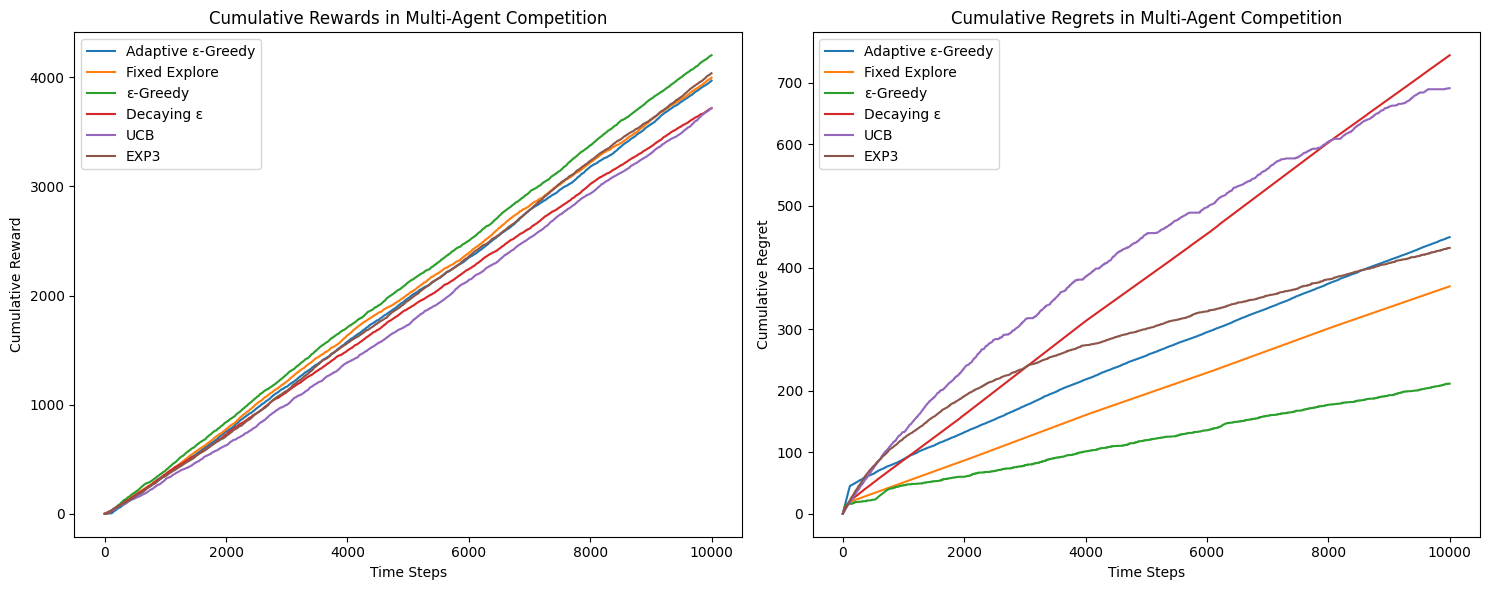

In [ ]:
# ==========================
# Multi-Agent Environment
# ==========================
class MultiAgentOTCEnvironment:
    """
    Simulates competitive market with multiple adaptive agents
    Aligns execution probabilities with single-agent OTCEnvironment logic
    """
    def __init__(self, spreads, num_agents=2, alpha=0.4, dynamic_interval=2000):
        self.spreads = np.array(spreads)
        self.num_agents = num_agents
        self.alpha = alpha
        self.dynamic_interval = dynamic_interval
        self.step_counter = 0
        self.competitor_spread = np.median(spreads)  # Initial competitor spread
        self.optimal_spread = None  # Track current optimal spread
        self._update_optimal_spread()  # Critical initialization
        
    def get_execution_prob(self, s):
        """Align with single-agent probability calculation"""
        if s < self.competitor_spread:
            return 1 / (1 + np.exp(self.alpha * (self.competitor_spread - s)))
        else:
            return 1 / (1 + np.exp(self.alpha * (s - self.competitor_spread + 0.1)))
    
    def update_competitor_spread(self):
        """Non-stationary dynamics: Change competitor spread periodically"""
        if self.step_counter % self.dynamic_interval == 0:
            # Move competitor spread randomly within interquartile range
            q1, q3 = np.quantile(self.spreads, [0.25, 0.75])
            self.competitor_spread = np.random.choice(
                self.spreads[(self.spreads >= q1) & (self.spreads <= q3)]
            )
            # Update optimal spread for regret calculation
            self._update_optimal_spread()
            
    def _update_optimal_spread(self):
        """Find current optimal spread considering competitor"""
        expected_rewards = [s * self.get_execution_prob(s) for s in self.spreads]
        self.optimal_spread = self.spreads[np.argmax(expected_rewards)]
    
    def pull_arms(self, arms):
        """Return rewards and instantaneous regrets"""
        self.step_counter += 1
        self.update_competitor_spread()
        
        rewards = []
        regrets = []
        selected_spreads = self.spreads[arms]
        
        # Get current optimal expected reward
        optimal_expected = self.optimal_spread * self.get_execution_prob(self.optimal_spread)
        
        for s in selected_spreads:
            prob = self.get_execution_prob(s)
            reward = np.random.binomial(1, prob) * s
            expected = s * prob
            regret = optimal_expected - expected
            
            rewards.append(reward)
            regrets.append(regret)
            
        return rewards, regrets

# ==========================
# Experiment Runner
# ==========================
def run_multi_agent_experiment(agent_configs, env_params, num_steps):
    """
    Returns:
    - cumulative_rewards: List of arrays (cumulative sum per agent)
    - cumulative_regrets: List of arrays (cumulative sum per agent) 
    - spread_history: Matrix of selected spreads
    """
    env = MultiAgentOTCEnvironment(**env_params)
    num_agents = len(agent_configs)
    
    # Initialize agents and metrics
    agents = [cls(**params) for cls, params in agent_configs]
    reward_history = np.zeros((num_steps, num_agents))
    regret_history = np.zeros((num_steps, num_agents))
    spread_history = np.zeros((num_steps, num_agents))
    
    for t in range(num_steps):
        arms = [agent.select_arm() for agent in agents]
        spread_history[t] = env.spreads[arms]
        
        # Get rewards and regrets
        rewards, regrets = env.pull_arms(arms)
        
        # Update agents and store metrics
        for i in range(num_agents):
            agents[i].update(arms[i], rewards[i])
            reward_history[t,i] = rewards[i]
            regret_history[t,i] = regrets[i]
    
    # Convert to cumulative sums
    cumulative_rewards = np.cumsum(reward_history, axis=0)
    cumulative_regrets = np.cumsum(regret_history, axis=0)
    
    return cumulative_rewards, cumulative_regrets, spread_history

# ==========================
# Experiment Setup
# ==========================
num_steps = 10000  # Simulation length 
alpha = 0.4 # High alpha means high competitiveness (steep execution prob curve)
dynamic_interval = 2000
# Agent configurations (mixed strategies)
agent_configs = [
    (AdaptiveEpsilonGreedy, {'num_arms': num_arms, 'k': k}),
    (FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': exploration_steps}),
    (EpsilonGreedy, {'num_arms': num_arms, 'epsilon': epsilon}),
    (EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}),
    (UCB, {'num_arms': num_arms, 'c': c}),
    (EXP3, {'num_arms': num_arms, 'gamma': gamma})
]

num_agents = len(agent_configs)
# Environment parameters
env_params = {
    'spreads': spreads,
    'num_agents': num_agents,
    'alpha': alpha,
    'dynamic_interval': dynamic_interval
}

# ==========================
# Running Experiments
# ==========================
cumulative_rewards, cumulative_regrets, spread_history = run_multi_agent_experiment(
    agent_configs, env_params, num_steps=num_steps
)

# ==========================
# Visualization
# ==========================
labels = ['Adaptive ε-Greedy', 'Fixed Explore', 'ε-Greedy', 'Decaying ε', 'UCB', 'EXP3']
plt.figure(figsize=(15, 6))

# Reward plot
plt.subplot(1, 2, 1)

for i in range(cumulative_rewards.shape[1]):
    plt.plot(cumulative_rewards[:,i], label=labels[i])
plt.title("Cumulative Rewards in Multi-Agent Competition")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()

# Regret plot
plt.subplot(1, 2, 2)
for i in range(cumulative_regrets.shape[1]):
    plt.plot(cumulative_regrets[:, i], label=labels[i])
plt.title("Cumulative Regrets in Multi-Agent Competition")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()